# Case Description

You were hired as a data scientist in an important mutual fund firm (investment company) in the department of financial analysis. The firm has been doing financial analysis and financial forecast for several years. You were hired to come up with alternative approaches to do descriptive analytics in order to find better future alternatives for forecasting methods.

You have to analyze historical quarterly financial statements of all US public firms listed in the New York Exchange and NASDAQ. You will receive two datasetsin .csv format. The first dataset (dataus2023q2) contains the historical financial data of the firms, while the second dataset (firmsus2023) is a catalog of all firms along with the corresponding industry type and status (active or cancelled).

The dataus2023q2 dataset has a panel-data (also called long format) structure. Each row has financial information for one US firm and 1 period (a quarter). All $ amounts are in thousands (’1000s).

The main objectives of your analysis are a) To learn about the firm composition of whole US financial market (using all firms), and b) Select firms from 1 industry and then learn which financial factors/variables are related to stock return.

In the following sections you will find specific directions to calculate new variables/ratios, provide descriptive statistics and do a statistical analysis to aim the objective.

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [138]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd
#put your own path in google drive
%cd "/content/gdrive/MyDrive/AI/Proyecto_Estadistica"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/AI/Proyecto_Estadistica
/content/gdrive/MyDrive/AI/Proyecto_Estadistica
dataus2023.csv	firmsus2023.csv


In [139]:
data = pd.read_csv("dataus2023.csv")
print(data.shape)

firms = pd.read_csv("firmsus2023.csv")
print(firms.shape)

(533088, 21)
(5615, 7)


In [140]:
data['qdate']=pd.PeriodIndex(data.q, freq="Q")

In [141]:
data.set_index(['firm', 'qdate'], inplace = True)

In [142]:
firms.columns
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ['firm', 'Empresa', 'status', 'industria']

# 1.1 Calculation of financial variables and ratios

* Calculate log quarterly returns (rq) and log annual returns (ry).

* Calculate 1-quarter future log quarterly returns (f1rq)

In [143]:
data['ry'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
data['rq'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))

data['f1rq'] = data['rq'].shift(-1)
data['f4rq'] = data['rq'].shift(-4)

In [144]:
data = pd.merge(data, firms1, on="firm", how='left')
data[['firm', 'q', 'rq', 'ry', 'f1rq', 'f4rq']].head(10)

,firm,q,rq,ry,f1rq,f4rq
0,A,2000q1,NaN,NaN,-0.343710,-0.577538
1,A,2000q2,-0.343710,NaN,-0.410137,0.056001
2,A,2000q3,-0.410137,NaN,0.112233,-0.508265
3,A,2000q4,0.112233,NaN,-0.577538,0.377280
4,A,2001q1,-0.577538,-1.219152,0.056001,0.203950
5,A,2001q2,0.056001,-0.819441,-0.508265,-0.390841
6,A,2001q3,-0.508265,-0.917569,0.377280,-0.593809
7,A,2001q4,0.377280,-0.652522,0.203950,0.318593
8,A,2002q1,0.203950,0.128965,-0.390841,-0.311725
9,A,2002q2,-0.390841,-0.317877,-0.593809,0.396554


In [145]:
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,sharesoutstanding,fixedassets,year,ry,rq,f1rq,f4rq,Empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,452000.000,NaN,2000,NaN,NaN,-0.343710,-0.577538,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,452271.967,1453000.0,2000,NaN,-0.343710,-0.410137,0.056001,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,453014.579,1581000.0,2000,NaN,-0.410137,0.112233,-0.508265,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,456366.381,1741000.0,2000,NaN,0.112233,-0.577538,0.377280,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,456769.737,1821000.0,2001,-1.219152,-0.577538,0.056001,0.203950,"Agilent Technologies, Inc",activo,Industrias manufactureras


* Calculate operating profit (also called earnings before interest and taxes) : ebit = revenue - cogs - sgae

* Calculate operating profit margin: opm = ebit / revenue

* Calculate net income as: netincome = ebit + otherincome + extraordinaryitems - financial expenses - incometax

* Calculate profit margin (ratio) as: pm = ni / revenue

* Calculate asset turn over ratio: ato = revenue / totalassets

* Calculate acid ratio: acidratio = currentassets / currentliabilities

* Calculate financial leverage ratio as: finlev=longdebt / totalassets

* Calculate market value as: mvalue = originalprice * sharesoutstanding

* Calculate book value as: bookvalue = totalassets - totalliabilities

In [146]:
data['ebit']= data['revenue'] - data['cogs'] - data['sgae']
data['opm']= np.where(data['revenue']==0,np.NaN,data['ebit']/data['revenue'])
data['netincome']= data['ebit'] - data['extraordinaryitems'] - data['incometax'] -data ['finexp']
data['pm']= np.where(data['revenue']==0,np.NaN,data['netincome']/data['revenue'])
data['ato']= np.where(data['totalassets']==0,np.NaN,data['revenue']/data['totalassets'])
data['acidratio']= np.where(data['currentliabilities']==0,np.NaN,data['currentassets']/data['currentliabilities'])
data['finlev']= np.where(data['totalassets']==0,np.NaN,data['longdebt']/data['totalassets'])
data['mvalue']= data['originalprice'] * data['sharesoutstanding']
data['bookvalue']= data['totalassets'] - data['totalliabilities']

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533088 entries, 0 to 533087
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   firm                533088 non-null  object 
 1   q                   533088 non-null  object 
 2   fiscalmonth         240848 non-null  float64
 3   revenue             240837 non-null  float64
 4   cogs                240837 non-null  float64
 5   sgae                209734 non-null  float64
 6   otherincome         240837 non-null  float64
 7   extraordinaryitems  209734 non-null  float64
 8   finexp              240837 non-null  float64
 9   incometax           240837 non-null  float64
 10  totalassets         240842 non-null  float64
 11  currentassets       234044 non-null  float64
 12  inventory           198227 non-null  float64
 13  totalliabilities    240841 non-null  float64
 14  currentliabilities  198231 non-null  float64
 15  longdebt            222677 non-nul

# 1.2 Firm Composition of the US financial market

In [147]:
data.status.unique()

array(['activo', 'cancelado'], dtype=object)

* Show how many active firms by industry there are in the sample

In [148]:
active_2023q2=data.loc[(data['status']=="activo")&(data['q']=="2023q2")]
active_2023q2[["industria", 'firm']].groupby('industria').count()

,firm
industria,
-,2
"Agricultura, ganadería, aprovechamiento forestal, pesca y caza",17
Comercio al por mayor,79
Comercio al por menor,145
Construcción,46
"Empresas de electricidad, gas y agua",77
Industrias manufactureras,1540
Información en medios masivos,256
"Minería, explotación de canteras y extracción de petróleo y gas",113


In [149]:
industrysummary = active_2023q2.groupby('industria').agg(
    {
    'firm':['count'],
    'mvalue': ['min', 'max', 'mean', 'median', 'std'],
    'bookvalue': ['min', 'max', 'mean', 'median', 'std']
    }
)
industrysummary

firm        mvalue  \
                                                   count           min   
industria                                                                
-                                                      2  5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...    17  3.687575e+03   
Comercio al por mayor                                 79  5.458413e+03   
Comercio al por menor                                145  3.795684e+03   
Construcción                                          46  2.212283e+03   
Empresas de electricidad, gas y agua                  77  3.372824e+04   
Industrias manufactureras                           1540  7.961721e+02   
Información en medios masivos                        256  3.256724e+03   
Minería, explotación de canteras y extracción d...   113  3.417000e+01   
Otros servicios excepto actividades gubernament...    17  1.674210e+04   
Servicios de alojamiento temporal y de preparac...    71  9.806644e+03   
Servicios de apoyo a los negocios y manejo de r...   128  2.802163e+03   
Servicios de esparcimiento culturales y deporti...    24  3.092327e+03   
Servicios de salud y de asistencia social             63  7.174165e+02   
Servicios educativos                                  13  8.398636e+04   
Servicios financieros y de seguros                   686  5.559044e+03   
Servicios inmobiliarios y de alquiler de bienes...    68  3.440615e+03   
Servicios profesionales, científicos y técnicos      137  3.638322e+03   
Transportes, correos y almacenamiento                 70  2.981646e+04   

                                                                  \
                                                             max   
industria                                                          
-                                                   5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...  4.505009e+07   
Comercio al por mayor                               5.764514e+07   
Comercio al por menor                               1.337540e+09   
Construcción                                        4.150495e+07   
Empresas de electricidad, gas y agua                1.501596e+08   
Industrias manufactureras                           3.050896e+09   
Información en medios masivos                       2.532081e+09   
Minería, explotación de canteras y extracción d...  6.980866e+07   
Otros servicios excepto actividades gubernament...  9.764061e+06   
Servicios de alojamiento temporal y de preparac...  2.174703e+08   
Servicios de apoyo a los negocios y manejo de r...  4.448753e+08   
Servicios de esparcimiento culturales y deporti...  1.631418e+08   
Servicios de salud y de asistencia social           8.351460e+07   
Servicios educativos                                3.171234e+06   
Servicios financieros y de seguros                  7.507354e+08   
Servicios inmobiliarios y de alquiler de bienes...  1.952017e+08   
Servicios profesionales, científicos y técnicos     1.519831e+09   
Transportes, correos y almacenamiento               1.539554e+08   

                                                                  \
                                                            mean   
industria                                                          
-                                                   5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...  7.682534e+06   
Comercio al por mayor                               6.028485e+06   
Comercio al por menor                               2.472093e+07   
Construcción                                        5.996741e+06   
Empresas de electricidad, gas y agua                1.544664e+07   
Industrias manufactureras                           1.290139e+07   
Información en medios masivos                       2.339430e+07   
Minería, explotación de canteras y extracción d...  6.854571e+06   
Otros servicios excepto actividades gubernament...  1.956204e+06   
Servicios de alojamiento temporal y de pre

* For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed? You have to do the right descriptive statistics

IN ORDER TO DESCRIBE THE TYPICAL FIRM SIZE IN ACCORDANCE TO THE MARKET VALUE AND THE BOOK VALUE, I WILL BE ANALYZING THE MEDIAN VALUES ACCORDINGLY, DUE THE FACT THAT THE MEAN, IN THIS CASE, DOES NOT REPRESENT THE TRUE 50TH PERCENTILE OF THE INDUSTRIES.

NOW WE'LL BE TAKING A LOOK WITHIN EACH INDUSTRY AND ANALYZING ITS PROPER MEDIAN FOR THE MARKET VALUE:

*Agriculture, ganadería, aprovechamiento forestal, pesca y caza:* The typical firm in this industry has a median market value of approximately $857,921.50.

 Market values vary with a standard deviation of approximately $1,516,353. This suggests significant variability in market values within this industry.

_Comercio al por mayor_: The typical firm in wholesale trade has a median market value of approximately $883,300.

 The standard deviation is approximately $3,028,155
indicating substantial variability in market values.

_Comercio al por menor_: Firms in retail trade have a median market value of approximately $5,443,400.

 Market values vary with a standard deviation of approximately $16,956,070, indicating significant variation.

_Industrias manufactureras_: Firms in manufacturing have a median market value of approximately $2,776,380.

The standard deviation is approximately $10,530,440, indicating notable variability in market values.

_Información en medios masivos_: Media firms have a median market value of approximately $5,079,650.

The standard deviation is approximately $18,389,290, suggesting substantial variation.

_Minería, explotación de canteras y extracción de petróleo y gas_: This industry has a median market value of approximately $9,985,605.

The standard deviation is approximately $5,908,949, indicating considerable variability in market values.

_Other Services_: The typical firm in this category has a median market value of approximately $1,463,740.

 The standard deviation is approximately $757,627.5, suggesting some variability in market values.

_Servicios de alojamiento temporal y de preparación de alimentos y bebidas_: Firms in this category have a median market value of approximately $2,073,125.

The standard deviation is approximately $2,312,744, indicating variability.

_Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación_: Firms in this category have a median market value of approximately $626,235.5.

 The standard deviation is approximately $6,367,508, indicating considerable variability.

_Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos_: This industry has a median market value of approximately $481,245.

 The standard deviation is approximately $21,692,360, indicating significant variation.

_Servicios de salud y de asistencia social_: The typical firm in this category has a median market value of approximately $489,998.

The standard deviation is approximately $1,678,627, suggesting some variability in market values.

_Servicios educativos_: Firms in education have a median market value of approximately $792,432.

 The standard deviation is approximately $996,208, indicating variability in market values.

_Servicios financieros y de seguros_: This industry has a median market value of approximately $1,191,918.

 The standard deviation is approximately $30,592,410, indicating notable variation.

_Servicios inmobiliarios y de alquiler de bienes muebles e intangibles_: The typical firm in this category has a median market value of approximately $613,070.

 The standard deviation is approximately $3,560,030, suggesting some variability in market values.

_Servicios profesionales, científicos y técnicos_: Firms in this category have a median market value of approximately $2,585,840.

The standard deviation is approximately $25,988,950, indicating substantial variation.

*Transportes, correos y almacenamiento*: This industry has a median market value of approximately $1,443,204.

 The standard deviation is approximately $6,284,040, indicating significant variability.




Industries like "Comercio al por menor," "Industrias manufactureras," "Información en medios masivos," and "Servicios financieros y de seguros" generally usually have higher median market values than other industries.

Most industries demonstrate significant variability in their market values, which is shown by noteworthy standard deviations.

However, "Comercio al por menor" and "Información en medios masivos"  have particularly high variability in market values.

The "Agricultura, ganadería, aprovechamiento forestal, pesca y caza" sector generally has lower median market values and less variation when compared to other sectors.

To put it briefly, the average size of a firm, as evaluated by its market value, differs considerably depending on the sector, with certain sectors having bigger typical firm sizes and greater variation than others.

Descriptive Statistics for book value



Summarizing the key points:

Variability Across Industries: Book values vary significantly across different industries, with some industries having much higher book values than others.

High Variability: Within most industries, there is considerable variability in book values, as indicated by notable standard deviations.

Retail and Media Industries: Retail trade and media industries tend to have relatively high median book values compared to other sectors.

Manufacturing: The manufacturing sector also exhibits notable variability in book values, with a wide range of firm sizes.

Services Industries: Various services industries, such as healthcare, education, and business support services, show some variability in book values, but they generally have lower median book values compared to other sectors.

Financial Services: The financial services industry stands out for having a relatively high median book value and significant variability in book values.

### Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?

In [150]:
active_2023q2[['firm','mvalue', 'Empresa', 'industria']].sort_values(by='mvalue', ascending=False).head(10)

,firm,mvalue,Empresa,industria
1138,AAPL,3.050896e+09,Apple Inc,Industrias manufactureras
316182,MSFT,2.532081e+09,Microsoft Corp,Información en medios masivos
207232,GOOGL,1.519831e+09,Alphabet Inc,"Servicios profesionales, científicos y técnicos"
28396,AMZN,1.337540e+09,"Amazon.Com, Inc",Comercio al por menor
338687,NVDA,1.044859e+09,Nvidia Corp,Industrias manufactureras
478367,TSLA,8.296811e+08,"Tesla, Inc",Industrias manufactureras
72866,BRK_A,7.507354e+08,Berkshire Hathaway Inc,Servicios financieros y de seguros
301173,META,7.354528e+08,"Meta Platforms, Inc","Servicios profesionales, científicos y técnicos"
489577,UNH,4.474912e+08,Unitedhealth Group Inc,Servicios financieros y de seguros
280653,LLY,4.451900e+08,Eli Lilly And Company,Industrias manufactureras


In [151]:
print(active_2023q2['mvalue'].median())

1170074.0124050002


When looking at the top 10 firms, whether by market value or book value, it makes more sense to use the median as the benchmark for the typical firm. This is because, in most cases, the median gives a more accurate picture of what an average firm in this group is like. If we were to use the average (mean), it could be skewed by firms with extremely high earnings. Essentially, the average is easily swayed by outliers, like firms that earn ten times more than the others.

In [152]:
median_mvalue = active_2023q2['mvalue'].median()
print(median_mvalue)

1170074.0124050002


In [153]:
# Calculate deviation from the median for each firm
top_10_firms['deviation_from_median'] = top_10_firms['bookvalue'] - median_mvalue
top_10_firms

,firm,bookvalue,Empresa,industria,deviation_from_median
72866,BRK_A,539883000.0,Berkshire Hathaway Inc,Servicios financieros y de seguros,5.387129e+08
259753,JPM,312516000.0,Jpmorgan Chase & Co,Servicios financieros y de seguros,3.113459e+08
53286,BAC,283319000.0,Bank Of America Corp,Servicios financieros y de seguros,2.821489e+08
207232,GOOGL,267141000.0,Alphabet Inc,"Servicios profesionales, científicos y técnicos",2.659709e+08
79421,C,209422000.0,Citigroup Inc,Servicios financieros y de seguros,2.082519e+08
525961,XOM,206997000.0,Exxon Mobil Corp,Industrias manufactureras,2.058269e+08
316182,MSFT,206223000.0,Microsoft Corp,Información en medios masivos,2.050529e+08
513136,WFC,181952000.0,Wells Fargo & Company,Servicios financieros y de seguros,1.807819e+08
28396,AMZN,168602000.0,"Amazon.Com, Inc",Comercio al por menor,1.674319e+08
127623,CVX,159298000.0,Chevron Corp,Industrias manufactureras,1.581279e+08


All of the listed firms are significantly larger than the typical size of a US firm in terms of market value, with differences ranging from hundreds of millions to billions of dollars.

### Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?

In [154]:
active_2023q2[['firm','bookvalue', 'Empresa', 'industria']].sort_values(by='bookvalue', ascending=False).head(10)

,firm,bookvalue,Empresa,industria
72866,BRK_A,539883000.0,Berkshire Hathaway Inc,Servicios financieros y de seguros
259753,JPM,312516000.0,Jpmorgan Chase & Co,Servicios financieros y de seguros
53286,BAC,283319000.0,Bank Of America Corp,Servicios financieros y de seguros
207232,GOOGL,267141000.0,Alphabet Inc,"Servicios profesionales, científicos y técnicos"
79421,C,209422000.0,Citigroup Inc,Servicios financieros y de seguros
525961,XOM,206997000.0,Exxon Mobil Corp,Industrias manufactureras
316182,MSFT,206223000.0,Microsoft Corp,Información en medios masivos
513136,WFC,181952000.0,Wells Fargo & Company,Servicios financieros y de seguros
28396,AMZN,168602000.0,"Amazon.Com, Inc",Comercio al por menor
127623,CVX,159298000.0,Chevron Corp,Industrias manufactureras


The table shows the top 10 US companies in terms of book value, all of them active during the second quarter of the year 2023. Another thing to denote is  that 50% of these companies operate in the financial and insurance services sector.

In [155]:
median_bookvalue = active_2023q2['bookvalue'].median()
print(median_bookvalue)

500654.5


In [156]:
# Calculate deviation from the median for each firm
top_10_firms['deviation_from_median'] = top_10_firms['bookvalue'] - median_bookvalue
top_10_firms


,firm,bookvalue,Empresa,industria,deviation_from_median
72866,BRK_A,539883000.0,Berkshire Hathaway Inc,Servicios financieros y de seguros,539382345.5
259753,JPM,312516000.0,Jpmorgan Chase & Co,Servicios financieros y de seguros,312015345.5
53286,BAC,283319000.0,Bank Of America Corp,Servicios financieros y de seguros,282818345.5
207232,GOOGL,267141000.0,Alphabet Inc,"Servicios profesionales, científicos y técnicos",266640345.5
79421,C,209422000.0,Citigroup Inc,Servicios financieros y de seguros,208921345.5
525961,XOM,206997000.0,Exxon Mobil Corp,Industrias manufactureras,206496345.5
316182,MSFT,206223000.0,Microsoft Corp,Información en medios masivos,205722345.5
513136,WFC,181952000.0,Wells Fargo & Company,Servicios financieros y de seguros,181451345.5
28396,AMZN,168602000.0,"Amazon.Com, Inc",Comercio al por menor,168101345.5
127623,CVX,159298000.0,Chevron Corp,Industrias manufactureras,158797345.5


These are the 10 biggest US firms in terms of book value, and each of them is significantly larger than the typical size of a US firm in terms of book value, with differences ranging from hundreds of millions to billions of dollars.

# Evolution of the US financial market

Considering the whole history of financial data for all firms, and only annual fiscal information (selecting fiscalmonth=12) :

* How the total market value of the US market has changed over the years? Do a table and/or graph and explain

* How total revenue and total net income of all US firms has changed over the years? Do a table and/or graph and explain

In [157]:
datay = data.loc[(data['fiscalmonth'] == 12) & (data['year'] < 2023)]
fmarket = datay[['year', 'mvalue', 'revenue', 'netincome']].groupby('year').sum()
fmarket

,mvalue,revenue,netincome
year,,,
2000,1.281498e+10,6.380673e+09,2.697602e+08
2001,1.149439e+10,7.493007e+09,1.241661e+08
2002,9.494723e+09,7.320441e+09,3.352811e+08
2003,1.167595e+10,7.924777e+09,3.194297e+08
2004,1.323088e+10,8.816237e+09,4.268007e+08
2005,1.378911e+10,9.645439e+09,4.789271e+08
2006,1.546125e+10,1.054036e+10,5.226893e+08
2007,1.614913e+10,1.125665e+10,5.098830e+08
2008,1.039502e+10,1.160798e+10,3.273042e+08


In [158]:
fmarket = fmarket.loc[fmarket.index]

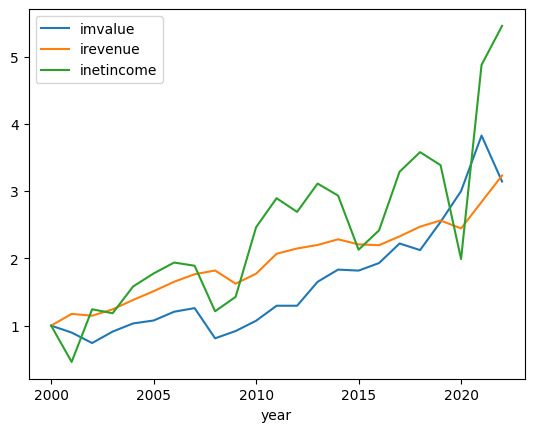

In [159]:
fmarket['imvalue'] = fmarket['mvalue'] / fmarket['mvalue'][2000]
fmarket['irevenue'] = fmarket['revenue'] / fmarket['revenue'][2000]
fmarket['inetincome'] = fmarket['netincome'] / fmarket['netincome'][2000]

fmarket.plot(y=['imvalue', 'irevenue', 'inetincome'])
plt.show()

From this graph we can extract the following:
The normalized total market value ('imvalue') of the US market appeared to lag behind the normalized total revenue ('irevenue') until roughly 2019. This suggests that, for a period, the overall market value of US firms wasn't growing as rapidly as their total revenue.

Around 2021 or 2022, 'imvalue' reached a peak, signifying a shift where market value started catching up and surpassing the total revenue. This could imply that investors began to place more value on the assets and potential growth of US firms.

By approximately 2023, 'imvalue' stabilized and remained slightly below 'irevenue.' This indicates that a relatively balanced relationship between the total market value and total revenue was established.


As for the netincome and the revenue,

'inetincome' consistently maintained a position above 'imvalue' and 'irevenue,' indicating that the aggregate net income of US firms exceeded both their total market value and total revenue.

A notable decline in 'inetincome' occurred in 2020, potentially influenced by various economic factors, notably the impact of the COVID-19 pandemic.

However, in subsequent years, 'inetincome' displayed a robust recovery and even surpassed both 'irevenue' and 'imvalue.' This suggests a significant resurgence in total net income, potentially reflecting improved profitability and economic conditions during those periods. Maybe even due to factors like economic incentives and a recovery from the COVID-19 pandemic.

As for the revenue:
'irevenue' has exhibited a sustained upward trajectory, implying a continuous increase in the aggregate revenue of US firms over the years.


In all 3 variables, we can see an overall positive (upwards) trend is highly related to the expansion and growth of the US market in recent years.

# Learing about one industry

In [160]:
#Select my Industry
#In this case we'll be analyzing the Service industries
dataser= data.loc[(data['industria']== 'Servicios de alojamiento temporal y de preparación de alimentos y bebidas') |
                  (data['industria']=='Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación') |
                  (data['industria']=="Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos") |
                  (data['industria']=="Servicios de salud y de asistencia social") |
                  (data['industria']=="Servicios educativos") |
                  (data['industria']=="Servicios profesionales, científicos y técnicos") |
                  (data['industria']=="Servicios inmobiliarios y de alquiler de bienes muebles e intangibles") |
                  (data['industria']=="Transportes, correos y almacenamiento")]
dataser[['industria']].head()

,industria
190,"Servicios profesionales, científicos y técnicos"
191,"Servicios profesionales, científicos y técnicos"
192,"Servicios profesionales, científicos y técnicos"
193,"Servicios profesionales, científicos y técnicos"
194,"Servicios profesionales, científicos y técnicos"


In [161]:
dataser2022 = dataser.loc[(dataser['year']==2022) & (dataser['fiscalmonth']==12) & (dataser['status']=='activo')]
dataser2022 = dataser2022[['firm','q','totalassets','revenue','netincome','mvalue','bookvalue','opm','pm','ato','finlev','acidratio','rq','ry','f1rq']]
dataser2022.describe()

,totalassets,revenue,netincome,mvalue,bookvalue,opm,pm,ato,finlev,acidratio,rq,ry,f1rq
count,5.550000e+02,5.550000e+02,5.500000e+02,5.500000e+02,5.550000e+02,545.000000,545.000000,555.000000,533.000000,527.000000,548.000000,540.000000,550.000000
mean,7.697660e+06,4.833988e+06,3.555505e+05,1.112014e+07,2.538049e+06,-2.118152,-2.765817,0.884458,0.332503,3.013270,-0.016142,-0.452699,0.033040
std,2.296538e+07,1.604355e+07,3.291170e+06,5.714457e+07,1.337700e+07,23.474751,34.774712,1.489658,0.291073,10.310960,0.289725,0.621442,0.266429
min,2.704282e+03,0.000000e+00,-1.675900e+07,3.455370e+03,-8.876000e+06,-459.916667,-755.416667,0.000000,0.000000,0.061452,-1.845058,-3.314782,-1.374598
25%,4.785685e+05,2.762975e+05,-2.898000e+04,3.219927e+05,7.116205e+04,-0.061337,-0.089161,0.364548,0.090553,1.000816,-0.121734,-0.685847,-0.082171
50%,1.733400e+06,9.679960e+05,1.827400e+04,1.444956e+06,4.802230e+05,0.060719,0.030860,0.627985,0.289875,1.465848,0.041209,-0.303200,0.042836
75%,5.945813e+06,3.663277e+06,2.125865e+05,5.335943e+06,1.665617e+06,0.152147,0.093356,1.071085,0.487532,2.378899,0.154247,-0.045514,0.166593
max,3.652640e+08,2.828360e+08,6.348600e+07,1.141961e+09,2.561440e+08,0.810083,0.686365,29.462489,1.959117,208.291382,0.883855,1.235678,1.205105


In [162]:
#Dataset con toda la historia, pero que sea información anual

#datasery = dataser[dataser['fiscalmonth']==12]
#datasery[['fiscalmonth','revenue']].head()

datasery = dataser.loc[(dataser['fiscalmonth']==12) & (dataser['status']== 'activo')]
datasery[['fiscalmonth','revenue']].head()

,fiscalmonth,revenue
478,12.0,19703000.0
482,12.0,18963000.0
486,12.0,17299000.0
490,12.0,17440000.0
494,12.0,18645000.0


In [163]:
# Calculo logaritmo de las variables financieras (no de los ratios)

datasery['logta'] = np.where(datasery['totalassets']==0,np.NaN,np.log(datasery['totalassets']))
datasery['logrev'] = np.where(datasery['revenue']==0,np.NaN,np.log(datasery['revenue']))
datasery['logni'] = np.where(datasery['netincome']==0,np.NaN,np.log(datasery['netincome']))

<ipython-input-163-ab480b9dbfd0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

<ipython-input-163-ab480b9dbfd0>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value enc

# Descriptive statistics for your industry

Using the subsample of your industry and using annual fiscal information (selecting rows with fiscalmonth=12), and the most recent complete year (2022), do the following:

* Show descriptive statistics for future quarterly log return, annual return, total assets, revenue, netincome and all financial ratios calculated above. Provide a clear interpretation of the descriptive statistics of revenue and 1 financial ratio

In [164]:
#selecciono las columnas de las variables a analizar
#'firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue'
dataset2022 = dataser.loc[(dataser['year']==2022)&(dataser['fiscalmonth']==12) & (dataser['status']=="activo")]
dataser2022

,firm,q,totalassets,revenue,netincome,mvalue,bookvalue,opm,pm,ato,finlev,acidratio,rq,ry,f1rq
566,AAL,2022q4,64716000.0,48971000.0,-198000.0,8.266739e+06,-5799000.0,0.032815,-0.004043,0.756706,0.500479,0.710318,0.054941,-0.344972,0.148068
2558,ABM,2022q4,4868900.0,7806600.0,225800.0,2.913982e+06,1717300.0,0.044680,0.028924,1.603360,0.244573,1.153710,0.154724,0.101936,0.016550
2748,ABNB,2022q4,16038000.0,8399000.0,1868000.0,5.413665e+07,5560000.0,0.214549,0.222407,0.523694,0.142287,1.862748,-0.205825,-0.666419,0.374986
3033,ABSI,2022q4,321008.0,5747.0,-107261.0,1.940293e+05,274414.0,-18.574909,-18.663825,0.017903,0.050002,6.173208,-0.399096,-1.362197,-0.182322
4075,ACCD,2022q1,1285529.0,310021.0,-122991.0,1.175789e+06,855794.0,-0.405537,-0.396718,0.241162,0.243598,3.661083,-0.406224,-0.949228,-0.864144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529474,YUMC,2022q4,11826000.0,9569000.0,544000.0,2.286705e+07,7148000.0,0.065733,0.056850,0.809149,0.164722,1.819021,0.146181,0.102143,0.150453
529759,Z,2022q4,6563000.0,1958000.0,-118000.0,7.657172e+06,4482000.0,-0.047497,-0.060266,0.298339,0.274112,13.344444,0.118521,-0.684260,0.322538
531184,ZIP,2022q4,714563.0,904649.0,56140.0,1.809248e+06,28620.0,0.107476,0.062057,1.266017,0.776107,4.876441,-0.004860,-0.417973,-0.029668
531561,ZM,2022q1,7551318.0,4099864.0,1331878.0,3.506630e+07,5780018.0,0.259421,0.324859,0.542934,0.011259,3.914567,-0.450309,-1.008206,-0.082284


In [165]:
dataset2022 = dataset2022[['firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue']]
dataset2022.describe()

,f1rq,ry,rq,totalassets,revenue,netincome,opm,pm,ato,finlev,acidratio,mvalue,bookvalue
count,550.000000,540.000000,548.000000,5.550000e+02,5.550000e+02,5.500000e+02,545.000000,545.000000,555.000000,533.000000,527.000000,5.500000e+02,5.550000e+02
mean,0.033040,-0.452699,-0.016142,7.697660e+06,4.833988e+06,3.555505e+05,-2.118152,-2.765817,0.884458,0.332503,3.013270,1.112014e+07,2.538049e+06
std,0.266429,0.621442,0.289725,2.296538e+07,1.604355e+07,3.291170e+06,23.474751,34.774712,1.489658,0.291073,10.310960,5.714457e+07,1.337700e+07
min,-1.374598,-3.314782,-1.845058,2.704282e+03,0.000000e+00,-1.675900e+07,-459.916667,-755.416667,0.000000,0.000000,0.061452,3.455370e+03,-8.876000e+06
25%,-0.082171,-0.685847,-0.121734,4.785685e+05,2.762975e+05,-2.898000e+04,-0.061337,-0.089161,0.364548,0.090553,1.000816,3.219927e+05,7.116205e+04
50%,0.042836,-0.303200,0.041209,1.733400e+06,9.679960e+05,1.827400e+04,0.060719,0.030860,0.627985,0.289875,1.465848,1.444956e+06,4.802230e+05
75%,0.166593,-0.045514,0.154247,5.945813e+06,3.663277e+06,2.125865e+05,0.152147,0.093356,1.071085,0.487532,2.378899,5.335943e+06,1.665617e+06
max,1.205105,1.235678,0.883855,3.652640e+08,2.828360e+08,6.348600e+07,0.810083,0.686365,29.462489,1.959117,208.291382,1.141961e+09,2.561440e+08


**Future Quarterly Log Return (f1rq):**

Mean: The average future quarterly log return is approximately 0.033.

Minimum: The smallest observed future quarterly log return is approximately -1.375.

Maximum: The largest observed future quarterly log return is approximately 1.205.

Std: The standard deviation of future quarterly log returns is roughly 0.266, indicating significant variability in this variable.

**Annual Return (ry):**

Mean: The average annual return is approximately -0.453.

Minimum: The smallest observed annual return is approximately -3.315.

Maximum: The largest observed annual return is approximately 1.236.

Std: The standard deviation of annual returns is about 0.621.

**Revenue:**

Mean: The average revenue is approximately $4.83 million.

Minimum: The smallest observed revenue is $0 (probably indicating firms with no recorded revenue).

Maximum: The largest observed revenue is approximately $282.84 million.

Std: The standard deviation of revenue is roughly $16.04 million, showing significant variability in revenue figures.

**Total Assets:**

Mean: The average total assets are approximately $7.70 million.

Minimum: The smallest observed total assets are approximately $2,704.

Maximum: The largest observed total assets are approximately $365.26 million.

Std: The standard deviation of total assets is about $22.97 million.

**Operating Profit Margin (opm):**

Mean: The average operating profit margin is approximately -2.12.

Minimum: The smallest observed operating profit margin is approximately -459.92.

Maximum: The largest observed operating profit margin is approximately 0.810.

Std: The standard deviation of operating profit margins is notably high at approximately 23.47, indicating variability in margin percentages.

Using annual fiscal data (selecting rows with fiscalmonth=12), and all years:

In [166]:
datasety= dataser.loc[(dataser['fiscalmonth']==12) & (dataser['status']=="activo")]
datasety = datasety[['firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue']]
datasety.describe()

,f1rq,ry,rq,totalassets,revenue,netincome,opm,pm,ato,finlev,acidratio,mvalue,bookvalue
count,6213.000000,5684.000000,6134.000000,6.516000e+03,6.515000e+03,6.481000e+03,6438.000000,6438.000000,6515.000000,6267.000000,6234.000000,6.158000e+03,6.516000e+03
mean,0.003135,0.026157,0.023147,6.311967e+06,4.023808e+06,2.962504e+05,-1.174258,-1.211593,0.947526,0.272559,2.353425,1.047869e+07,2.213705e+06
std,0.273399,0.506159,0.251749,1.603412e+07,1.018310e+07,1.894726e+06,28.036721,26.494866,1.004083,0.291646,5.311153,5.719124e+07,9.315745e+06
min,-2.280112,-4.915325,-2.202502,7.380000e-01,0.000000e+00,-1.675900e+07,-1404.971429,-1226.314286,0.000000,0.000000,0.002831,1.125142e+03,-2.556000e+07
25%,-0.091097,-0.173667,-0.081685,3.840415e+05,2.703370e+05,-5.321000e+03,0.009073,-0.021266,0.421911,0.043958,0.987058,4.504288e+05,9.703625e+04
50%,0.029913,0.083238,0.043669,1.560290e+06,1.082158e+06,3.947600e+04,0.077157,0.041470,0.717154,0.226712,1.426676,1.702196e+06,4.879025e+05
75%,0.138925,0.298886,0.159373,5.301045e+06,3.616307e+06,2.070000e+05,0.161017,0.097481,1.239240,0.410432,2.224119,5.618335e+06,1.606816e+06
max,2.023202,2.930813,1.625311,3.652640e+08,2.828360e+08,6.401300e+07,7.170382,46.390129,32.355468,7.477906,208.291382,2.256959e+09,2.561440e+08


* Show a correlation matrix with the same variables you used for descriptive statistics above, but in the case of totalassets, revenue and netincome, use the logarithmic transformation of their values. Which variables have strongest and significant linear relationship with stock returns (annual and quarterly)? Explain

In [167]:
#calculo el logaritmo de las variables financieras (no de los ratios)
datasety['logta'] = np.where(datasety['totalassets']==0, np.NaN,np.log(datasety['totalassets']))
datasety['logrev'] = np.where(datasety['revenue']==0, np.NaN,np.log(datasety['revenue']))
datasety['logni'] = np.where(datasety['netincome']==0, np.NaN,np.log(datasety['netincome']))
datasety[['firm', 'logta', 'logrev', 'logni']].head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



,firm,logta,logrev,logni
478,AAL,17.081766,16.796281,13.425427
482,AAL,17.307188,16.758000,NaN
486,AAL,17.225569,16.666159,NaN
490,AAL,17.194121,16.674277,NaN
494,AAL,17.174948,16.741089,NaN


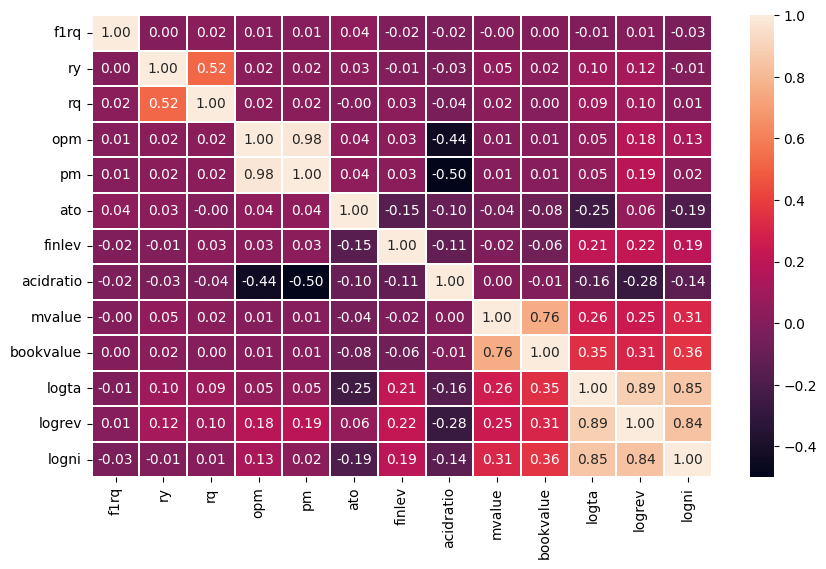

In [168]:
#Calculate the correlation matrix
corr_matrix = datasety[['f1rq', 'ry', 'rq', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue', 'logta', 'logrev', 'logni']].corr()
plt.figure(figsize=(10,6))
sn.heatmap(corr_matrix, annot = True,linewidths=0.3,fmt='0.2f')
plt.show()

The correlation matrix analysis reveals that the variables most closely associated with rq (quarterly stock returns) and ry (annual stock returns) are logta (log of total assets) and logrev (log of revenue). This observation is substantiated by the correlation coefficients:

***For rq:***

1. The correlation with logta is approximately 0.09.
1. The correlation with logrev is approximately 0.10.

***For ry:***

1. The correlation with logta is approximately 0.10.
1. The correlation with logrev is approximately 0.12.

These positive correlation coefficients imply a weak positive linear relationship between both quarterly and annual stock returns and the logarithmic transformations of total assets (logta) and revenue (logrev). However, it's crucial to note that these correlations are relatively weak, with coefficients below the 0.2 threshold. This suggests that while there is a discernible positive linear connection, it lacks substantial strength.

In [169]:
datasery.reset_index().head()

,index,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,...,netincome,pm,ato,acidratio,finlev,mvalue,bookvalue,logta,logrev,logni
0,478,AAL,2000q4,12.0,19703000.0,0.0,18322000.0,68000.0,34000.0,162000.0,...,677000.0,0.034360,0.751650,0.740916,0.208828,NaN,7176000.0,17.081766,16.796281,13.425427
1,482,AAL,2001q4,12.0,18963000.0,0.0,21433000.0,-2000.0,0.0,284000.0,...,-1760000.0,-0.092812,0.577418,0.870607,0.299443,NaN,5373000.0,17.307188,16.758000,NaN
2,486,AAL,2002q4,12.0,17299000.0,0.0,20629000.0,-2000.0,-988000.0,528000.0,...,-1533000.0,-0.088618,0.571547,0.681906,0.406714,NaN,957000.0,17.225569,16.666159,NaN
3,490,AAL,2003q4,12.0,17440000.0,0.0,18284000.0,113000.0,0.0,577000.0,...,-1341000.0,-0.076892,0.594613,0.713828,0.447528,NaN,46000.0,17.194121,16.674277,NaN
4,494,AAL,2004q4,12.0,18645000.0,0.0,18789000.0,108000.0,0.0,725000.0,...,-869000.0,-0.046608,0.648003,0.708321,0.470024,NaN,-581000.0,17.174948,16.741089,NaN


In [180]:
#In this section we're going to extract the 3 most correlated variables

correlations = datasety.corr()['f1rq'].abs()  # Calculate absolute correlations

sorted_correlations = correlations.sort_values(ascending=False)

# Extract the top 3 most correlated variables (excluding 'f1rq' itself)
top_3_correlated = sorted_correlations[1:7]

# Print the top 3 most correlated variables and their correlation values
for variable, correlation in top_3_correlated.items():
    print(f"Variable: {variable}, Correlation: {correlation}")



Variable: ato, Correlation: 0.04194887584822362
Variable: logni, Correlation: 0.03297259446909673
Variable: acidratio, Correlation: 0.023208813489088435
Variable: rq, Correlation: 0.019752231608441806
Variable: finlev, Correlation: 0.016852088751338277
Variable: logta, Correlation: 0.014410611703895388


<ipython-input-180-53d92e70bef0>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [171]:
import pandas as pd

ratio_variables = ['pm', 'ato', 'acidratio', 'finlev']
#In this section we're going to extract the 3 most correlated ratios

# Calculate correlations between the ratio variables and 'f1rq'
correlations = datasety[ratio_variables].corrwith(datasety['f1rq']).abs()

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Extract the top 3 most correlated ratio variables
top_correlated_ratios = sorted_correlations[0:3].index.tolist()

print("Top 3 most correlated ratio variables with 'f1rq':", top_correlated_ratios)

Top 3 most correlated ratio variables with 'f1rq': ['ato', 'acidratio', 'finlev']


Select 2-3 variables and 2-3 ratios with the strongest correlation with future log quarterly returns and do the following:

The variables with the strongest correlation with future log quarterly returns are the following:
1. *ato*: asset turnover ratio
2. *logni*: natural logarithm of net income
3. _acidratio_: acid ratio

However, since some of the variables are also ratios, then we might have the following list for variables:
1. *logni* natural logarithm of net income
1. *rq* quartely returns
1. *logta* natural logarithm of total assets

The ratios with the strongest correlations with f1rq were the following:
1. *ato* asset turnover ratio
1. _acidratio_ acid ratio
1. _finlev_  financial leverage ratio



* Do histograms for each factor/variables and interpret them

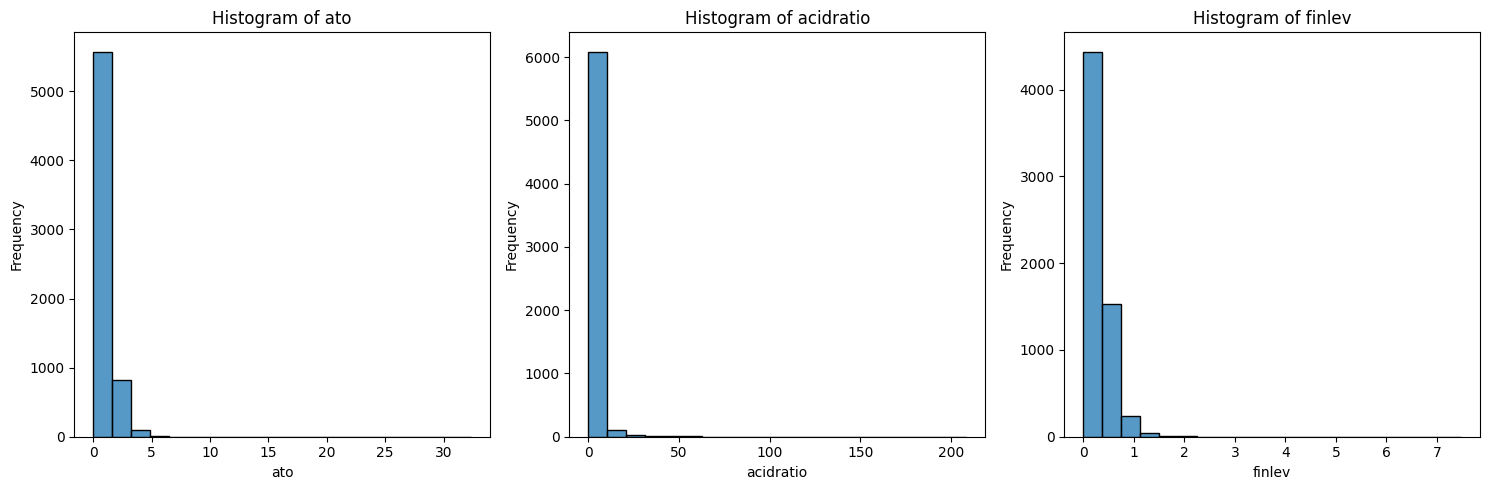

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Histograms for ratios

# Plot the histogram for 'ato'
sns.histplot(datasety['ato'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of ato')
axes[0].set_xlabel('ato')
axes[0].set_ylabel('Frequency')

# Plot the histogram for 'acidratio'
sns.histplot(datasety['acidratio'], bins=20, ax=axes[1])
axes[1].set_title('Histogram of acidratio')
axes[1].set_xlabel('acidratio')
axes[1].set_ylabel('Frequency')

# Plot the histogram for 'finlev'
sns.histplot(datasety['finlev'], bins=20, ax=axes[2])
axes[2].set_title('Histogram of finlev')
axes[2].set_xlabel('finlev')
axes[2].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the histograms
plt.show()


**ato**

Has a very skewed to the right behaviour in which the hightest frequency turns out to be above 5000. In this case, the graph implies that a majority of the entities or observations in the dataset have a high asset turnover ratio. This implies that many companies or entities are efficient in using their assets to generate.


**acidratio**

Now regarding the acid ratio, it appears to be a strong right-skewed histogram with a peak frequency of around 6000. and the acid ratio range going from 0 to 200.

The right-skewed distribution of the acid ratio suggests that a significant portion of the observed data points falls on the higher end of the scale. The acid ratio, also known as the quick ratio, measures a company's ability to meet short-term financial obligations without relying on the sale of inventory. In this context, a higher acid ratio typically indicates a healthier financial position and a lower risk of liquidity issues.


**finlev**

In this right-skewed distribution of the financial leverage ratio most of the observed data points falls on the higher end of the scale. The financial leverage ratio measures the extent to which a company relies on debt financing. A higher ratio typically indicates higher financial leverage and potentially higher financial risk.

Businesses around the 5000s may have higher financial leverage, possibly due to strategic decisions aimed at growth through debt financing, while those around 1500s may prioritize lower debt levels for risk mitigation.

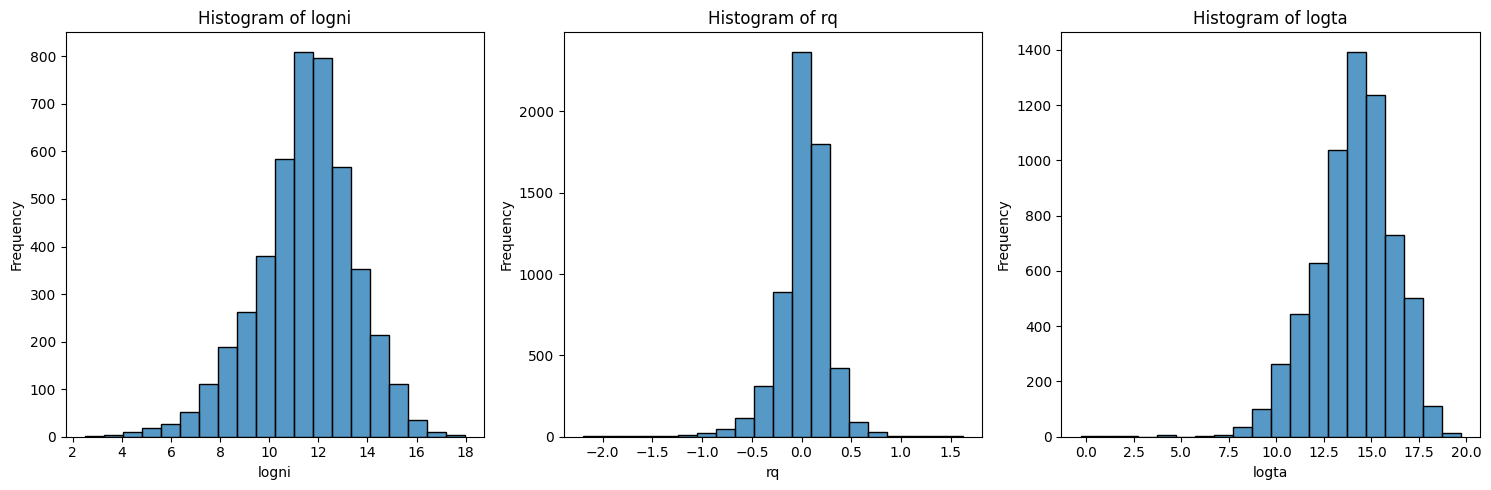

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Histograms for variables

# Plot the histogram for 'logni'
sns.histplot(datasety['logni'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of logni')
axes[0].set_xlabel('logni')
axes[0].set_ylabel('Frequency')

# Plot the histogram for 'rq'
sns.histplot(datasety['rq'], bins=20, ax=axes[1])
axes[1].set_title('Histogram of rq')
axes[1].set_xlabel('rq')
axes[1].set_ylabel('Frequency')

# Plot the histogram for 'logta'
sns.histplot(datasety['logta'], bins=20, ax=axes[2])
axes[2].set_title('Histogram of logta')
axes[2].set_xlabel('logta')
axes[2].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the histograms
plt.show()

**logni**

Now regarding the natural logarithm of netincome:
The x-axis represents the natural logarithm of net income (logni) with a range from 0 to 20, and the y-axis represents frequency, ranging from 0 to 1000. This suggests that the majority of observations fall within the x-axis range of 0 to 20, with a peak frequency around 800.

The relatively close-to-normal distribution of the logged net income suggests that service industries may exhibit a degree of income stability.

The fact that the mean of logged net income is around 12 might indicate that, on average, service-based businesses experience consistent and sustainable growth.

* Do plots to visualize the possible relationship each factor might have with quarterly returns (the dependent variable).

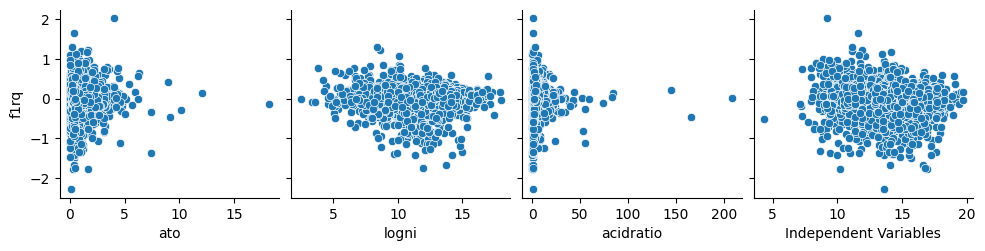

In [182]:
sn.pairplot(data=datasety, y_vars=['f1rq'], x_vars=['ato', 'logni', 'acidratio', 'logta'])

plt.xlabel('Independent Variables')
plt.ylabel('Quarterly Returns (rq)')

plt.show()

* Design and run a first version of a multiple regression model to examine whether your selected factors can explain/predict quarterly stock returns.



In [185]:
#datasetnad = datasety.dropna()

X = datasety[['acidratio', 'logni', 'ato', 'finlev']]
X = sm.add_constant(X)

Y = datasety[['f1rq']]
mkmodel = sm.OLS(Y, X,missing= "drop").fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.291
Date:                Mon, 11 Sep 2023   Prob (F-statistic):             0.0106
Time:                        14:22:51   Log-Likelihood:                 341.31
No. Observations:                4266   AIC:                            -672.6
Df Residuals:                    4261   BIC:                            -640.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.023      1.417      0.1

* You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test



In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X should already be defined as the independent variables with a constant term added
# Replace the column names below with the actual column names in your dataset
X_columns = ['acidratio', 'logni', 'ato', 'finlev']

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = X_columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif)

MissingDataError: ignored

In simple terms, multicollinearity consists when two or more independent variables in a regression model are highly related or correlated. It's like having redundant information in your data because these variables move together, making it hard to tell which one is actually influencing the dependent variable.

* (OPTIONAL) For each independent variable (variable/ratio) check if winsorization is needed according to very extreme values. You can check this with the histograms of each variable/ratio. If it is necessary do the corresponding adjustments with winsorization to avoid unreliable results in your regression model

* Once you corrected your variables/ratios with winsorization (in case you did it) and addressed possible multicollienarity problems, run a final multiple regression model

# Interpret your model

In [189]:
#datasetnad = datasety.dropna()

X = datasety[['acidratio', 'logni', 'ato', 'finlev']]
X = sm.add_constant(X)

Y = datasety[['f1rq']]
mkmodel = sm.OLS(Y, X,missing= "drop").fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.291
Date:                Mon, 11 Sep 2023   Prob (F-statistic):             0.0106
Time:                        14:27:19   Log-Likelihood:                 341.31
No. Observations:                4266   AIC:                            -672.6
Df Residuals:                    4261   BIC:                            -640.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.023      1.417      0.1

* Interpret with your own words the results of each coefficient (beta and their statistical significance)

* Interpret the R-squared of the model

* Write a conclusion of your results

***Interpretation of Coefficients (Beta) and Their Statistical Significance:***

Const (intercept): The constant term doesn't seem to have a strong influence on our dependent variable (f1rq). Its value of 0.0332 doesn't significantly affect f1rq because the p-value (0.156) is higher than the usual threshold (0.05). This means that when all other factors are zero, this constant doesn't have a strong influence on f1rq.

Acid ratio: A higher acid ratio (by 1 unit) seems to contribute slightly to an increase in f1rq of 0.0020. However, this relationship isn't very reliable as the p-value (0.166) is greater than 0.05. Therefore, we can't say with certainty that the acid ratio has a significant effect on f1rq.

Natural logarithm of net income (logni): A 1 unit increase in the natural logarithm of net income is associated with a 0.0020 decrease in f1rq. However, as with the acid ratio, this relationship isn't strong as the p-value (0.267) is higher than 0.05.

Asset turnover (ATO): An increase of 1 unit in asset turnover corresponds to an increase of 0.0069 in f1rq. While it seems to matter somewhat, we can't be sure because the p-value (0.142) is above 0.05.

Financial leverage (finlev): An increase of 1 unit in financial leverage leads to a decrease of 0.0251 in f1rq. This relationship is somewhat significant with a p-value of 0.077, but it's not very strong. We should be cautious about its significance.

***Interpretation of R-squared (R²):***

Only 0.3% of the variability in f1rq is explained by the independent variables (acid ratio, logni, ato, finlev) in the model, as indicated by the R-squared value of 0.003. The model does not do a good job of explaining or predicting the variation in f1rq. This means that most of the variability remains unaccounted for.

***Conclusion:***

Overall, based on this regression analysis, it appears that the selected independent variables (acidratio, logni, ato, finlev) have a limited or no statistically significant effect on f1rq. The low R-squared value of the model suggests that these variables, as currently included in the model, do not provide a strong explanation for the variation in f1rq.


